# Time series exploration

Purpose of this notebook is to detect timeseries anomalies 

## Data that we will use

The dataset has 4 columns, the first three represent accelerations in the principal DoF (x,y,z) and the last one represents the type of activity. 

These are detailed below:
--- 1: Working at Computer
--- 2: Standing Up, Walking and Going updown stairs
--- 3: Standing
--- 4: Walking
--- 5: Going UpDown Stairs
--- 6: Walking and Talking with Someone
--- 7: Talking while Standing
The accelerations are not in SI units, however they share the same 'units'. 

The dataset is from  UCI.

## Libraries

In [2]:
# mathematical libraries
import numpy as np
import scipy.fft as fft
from scipy.spatial.distance import cdist  


# data processing libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# data visualisation
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# modelling
from fbprophet import Prophet
from sklearn.cluster import KMeans 
from sklearn.ensemble import IsolationForest



## Cluster class

In [23]:
class Cluster:
    def __init__(self,X=None,y=None,labels=None):
        self.X = X
        self.y = y #y represents the 'ground truth' category
        self.labels = labels
        #labels isn't very smart as you won't always need the labels (in the case of plotting...)
        #is there a way to circumvent this?
    
    def save(self,path):
        with open (path,"wb") as f:
            pickle.dump(self.model,f)
            
            
class K_Mean_Clustering(Cluster):
    def __init__(self,X,y,labels):
        super().__init__(X,y,labels)
        self.model = None
        self.n_clusters = None
        self.predict = None
        
    def FitModel(self,n_clusters = 2, n_init = 12):
        k_means = KMeans(init = "k-means++", n_clusters = n_clusters, n_init = n_init)
        self.n_clusters = n_clusters
        self.model = k_means.fit(self.X)
        self.predict = k_means.predict(self.X)
    
    def plot(self,x_axis=0,y_axis=1):
        fig = plt.figure(figsize=(6,4))
        colors = plt.cm.rainbow(np.linspace(0,1,len(set(self.model.labels_))))
        ax = fig.add_subplot(1,1,1)
        for k,col in zip(range(self.n_clusters),colors):
            my_clusters = (self.model.labels_ == k) 
            cluster_center = self.model.cluster_centers_[k]
            ax.plot(self.X[my_clusters, x_axis], self.X[my_clusters, y_axis], 'w', markerfacecolor=col, marker='.')
            ax.plot(cluster_center[x_axis], cluster_center[y_axis], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)
        ax.set_title('KMeans, {} clusters'.format(self.n_clusters))
        ax.set_xlabel(self.labels[x_axis])
        ax.set_ylabel(self.labels[y_axis])
        ax.set_xticks(())
        ax.set_yticks(())
        plt.show()
        
    def evaluate(self):
        distortions = []
        inertias = []
        K = []
        for k in range(1,11):
            K_mean = KMeans(n_clusters = k, n_init = 12).fit(self.X)
            distortions.append(sum(np.min(cdist(self.X, K_mean.cluster_centers_,'euclidean'),axis=1))\
                               / self.X.shape[0])
            inertias.append(K_mean.inertia_) 
            K.append(k)
        fig = plt.figure(figsize=(6,4))
        ax = fig.add_subplot(1,1,1)

        ax.plot(K,distortions/ np.linalg.norm(distortions))
        ax.plot(K,inertias/ np.linalg.norm(inertias))
        ax.set_xticks(K)
        plt.legend(labels = ['distortions','inertias'])
        plt.show()
        

class iForest(Cluster):
    def __init__(self,X,y,labels):
        super().__init__(X,y,labels)
        self.model = None
        
    def FitModel(self, contamination = 0.01):
        iForest = IsolationForest(contamination = contamination)
        self.model = iForest.fit(X)
        self.predict = iForest.predict(X)

    def plot(self,x_axis = 0,y_axis = 1):
        anomalies = []
        normal = []
        for row,anomaly in zip(self.X,self.predict):
            if anomaly == 1:
                normal.append(row)
            else:
                anomalies.append(row)
        fig = plt.figure(figsize=(6,4))
        ax = fig.add_subplot(1,1,1)
        ax.plot(anomalies[x_axis],anomalies[y_axis],'rx')
        ax.plot(normal[x_axis],normal[y_axis],'b.')
            
            
    
    #def evaluate():
     #   pass
        

In [4]:
path = '~/KinKeepers/ProjectAI/Data/UCIActivityData.csv'
df = pd.read_csv(path,header =None, index_col = False)
df.head()

,0,1,2,3,4
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


## Data preparation

In [5]:
df.columns = ['ds','ax','ay','az','act_type']
#each measurement was sampled at 52 Hz...
#so:
freq = 52 #in hertz
df.ds = df.ds*(1/freq)
df['A'] = np.sqrt(np.power(df[['ax','ay','az']],2).sum(axis = 1))

df = df.iloc[400:]
df.head()

,ds,ax,ay,az,act_type,A
400,7.692308,1940,2368,2151,1,3741.366729
401,7.711538,1936,2371,2153,1,3742.344987
402,7.730769,1939,2379,2154,1,3749.543706
403,7.750000,1943,2379,2154,1,3751.613786
404,7.769231,1942,2363,2157,1,3742.697156


In [6]:
df.tail(15)
#this type of dataset will NOT work with prophet...
#any other methods that could be used for this?

,ds,ax,ay,az,act_type,A
162486,3124.807692,1929,2386,2076,7,3704.566506
162487,3124.807692,1928,2385,2077,7,3703.962473
162488,3124.807692,1925,2383,2079,7,3702.236486
162489,3124.807692,1931,2386,2073,7,3703.928455
162490,3124.807692,1931,2383,2076,7,3703.677362
162491,3124.807692,1927,2383,2079,7,3703.276792
162492,3124.807692,1931,2388,2076,7,3706.896411
162493,3124.807692,1932,2383,2072,7,3701.958536
162494,3124.807692,1931,2386,2073,7,3703.928455
162495,3125.000000,1926,2382,2072,7,3698.186583


## Data visualisation

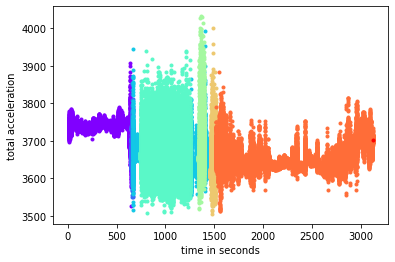

In [7]:
colors = cm.rainbow(np.linspace(0, 1, len(df.act_type.unique())))
for i,color in zip(df.act_type.unique(),colors):
    plt.plot(df.ds[df.act_type == i ],df.A[df.act_type == i],'.',c=color)
plt.xlabel('time in seconds')
plt.ylabel('total acceleration')
plt.show()

In [8]:
X = np.asarray(df[['ds','A']])
MinMax = MinMaxScaler()
MinMax.fit(X)
X = MinMax.transform(X)

In [9]:
IsoForest = IsolationForest(100,contamination=0.01)
IsoForest.fit(X)
anomalies = IsoForest.predict(X)
normS = []
normA = []
for i in X:
    normS.append(i[0])
    normA.append(i[1])

df['normS'] = normS
df['normA'] = normA
df['anomalies'] = anomalies
df.head()

/Users/yousefnami/python_environments/KinKeepers_AI/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_estimators=100 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


,ds,ax,ay,az,act_type,A,normS,normA,anomalies
400,7.692308,1940,2368,2151,1,3741.366729,0.000000,0.448801,1
401,7.711538,1936,2371,2153,1,3742.344987,0.000006,0.450657,1
402,7.730769,1939,2379,2154,1,3749.543706,0.000012,0.464312,1
403,7.750000,1943,2379,2154,1,3751.613786,0.000019,0.468239,1
404,7.769231,1942,2363,2157,1,3742.697156,0.000025,0.451325,1


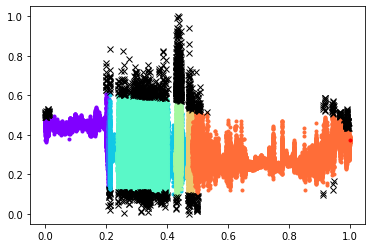

In [10]:
colors = cm.rainbow(np.linspace(0, 1, len(df.act_type.unique())))
for i,color in zip(df.act_type.unique(),colors):
    plt.plot(df.normS[(df.act_type == i) & (df.anomalies == 1)],df.normA[(df.act_type == i) & (df.anomalies == 1)],'.',c=color)
    plt.plot(df.normS[(df.act_type == i) & (df.anomalies == -1)],df.normA[(df.act_type == i) & (df.anomalies == -1)],'x',c='black')

/Users/yousefnami/python_environments/KinKeepers_AI/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  """


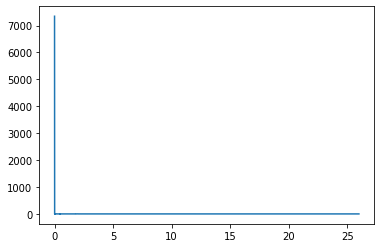

In [11]:
""" Not working at the moment: fourier to find the frequencies at play """

num_points = df.shape[0]
T = 1/freq
Y = fft(df.A)
xf = np.linspace(0.0, 1.0/(2.0*T), num_points//2)
plt.plot(xf,2.0/num_points * np.abs(Y[0:num_points//2]))
plt.show()

In [12]:
Cluster.__subclasses__()
#this is promising... but you seriously need to work on your classes!
#watch some videos on object oriented programming, specifically what *args and **kwargs mean !

[__main__.K_Mean_Clustering, __main__.iForest]

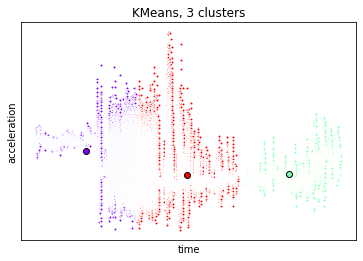

In [24]:
Kmeans = K_Mean_Clustering(X=np.asarray(df[['ds','A']]), labels = ['time','acceleration'],y=None)
Kmeans.FitModel(n_clusters = 3)
Kmeans.plot()